In [50]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using CircularArrays
using Random



@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties
@from "$(projectdir())/src/spatialData.jl" using SpatialData

In [3]:
function get_Q(cellPerimeters,edgeTangents,B̄) 
    Q = Matrix{Float64}[]
    for i=1:length(cellPerimeters)
        sum_j = zeros(2,2)
        for j=1:length(edgeTangents)
            sum_j += B̄[i,j].*edgeTangents[j]*normalize(edgeTangents[j]')
        end
        Qᵢ = sum_j./cellPerimeters[i] 
        push!(Q,Qᵢ)
    end
    return Q
end


function get_J(cellPerimeters, edgeTangents, B̄)
    Q=get_Q(cellPerimeters, edgeTangents, B̄)
    J=Q.-(I./2)
end

function get_vert_order(A,B, i)
    # Find all edges and vertices for cell i
    cellEdges, edgeOrientations = findnz(B[i, :])
    N = length(cellEdges)

    orderedVerticesAroundEdges = zeros(Int64, N, 2)
    # orderedVerticesAroundEdges = MMatrix{N,2,Int64}(zeros(Int64,N,2))
    for j = 1:N
        verts, orients = findnz(A[cellEdges[j], :])
        orderedVerticesAroundEdges[j, :] = verts[sortperm(edgeOrientations[j] .* orients)]
    end

    orderedVerts = CircularArray(ones(Int64, N)) # Ordered list of vertices around cell i in clockwise direction 
    orderedEdges = CircularArray(ones(Int64, N)) # Ordered list of edges around cell i in clockwise direction

    for j = 1:N
        orderedVerts[j] = orderedVerticesAroundEdges[orderedEdges[j-1], 2]
        orderedEdges[j] = findfirst(x -> x == orderedVerts[j], @view orderedVerticesAroundEdges[:, 1])
    end
    orderedEdges .= cellEdges[orderedEdges[0:N-1]]

    return orderedVerts, orderedEdges
end

function get_Polygons(R,nCells, cellVertexOrders)
    cellPolygons = Vector{Point{2,Float64}}[]
    for i=1:nCells
        push!(cellPolygons,Point{2,Float64}.(R[cellVertexOrders[i]]))
    end
    return cellPolygons
end

get_Polygons (generic function with 1 method)

In [34]:
f=Glob.glob("Large_Layers/quadratic_energy/Gamma_0.2_L0_0.75","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("systemData_n_1000.jld2",f)[end]
@unpack R, matrices, params = load(ff)
@unpack nCells,nVerts, nEdges, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ = matrices
mkpath(datadir(f,"patch_stress"))


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\Large_Layers\\quadratic_energy\\Gamma_0.2_L0_0.75\\patch_stress"

In [549]:
F=[1.25 0 ; 0 0.9]

Rs=[SVector{2, Float64}(F*R[n]) for n in 1:nVerts]

998-element Vector{SVector{2, Float64}}:
 [3.9730801094722774, -2.122596164769022]
 [4.8389052454999035, -2.433840446588651]
 [-1.7229932374250987, -3.6915421888974977]
 [-3.046257620155119, -2.0628595740569224]
 [-2.2043666805485236, -0.42092261634364975]
 [-0.08516485509608265, 0.43920343018487573]
 [2.57683129024589, -5.614454362011375]
 [-5.738432433174605, -5.420651034448099]
 [-7.175415418008109, -0.06410577669952382]
 [-3.5365709556615466, 5.429984516428674]
 ⋮
 [-2.1766774714104584, -1.2014095421545963]
 [-6.498392015333872, -0.6551082270100188]
 [-5.910319240135667, -0.9082858166579402]
 [1.5034111240435286, -5.763319569934855]
 [0.742175858525973, -5.789728450864382]
 [-5.494707499949781, 0.7836142470507612]
 [-5.671383152669295, 0.3889679536943782]
 [-2.74007153654551, -0.025320919481015267]
 [-3.098814545748891, -0.3000093692764525]

In [550]:
spatialData!(Rs,params,matrices)
@unpack nCells,nVerts, nEdges, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ = matrices

Reconstruct@MatricesContainer(Any[sparse([1, 659, 1481, 68, 576, 600, 27, 51, 836, 3, 4, 1184, 5, 806, 1209, 209, 384, 402, 7, 8, 938, 9, 155, 918, 90, 159, 353, 12, 444, 708, 16, 290, 827, 18, 425, 1409, 417, 564, 1289, 17, 210, 950, 15, 415, 687, 13, 86, 95, 25, 312, 1019, 309, 428, 602, 24, 29, 1070, 30, 302, 912, 117, 363, 729, 7, 18, 956, 26, 59, 965, 76, 141, 470, 240, 284, 1304, 34, 620, 857, 41, 269, 342, 360, 716, 917, 23, 52, 992, 43, 503, 744, 229, 519, 987, 12, 800, 1472, 177, 1031, 1076, 3, 803, 1263, 44, 274, 743, 19, 476, 1247, 14, 56, 1118, 15, 143, 1391, 26, 263, 738, 2, 60, 875, 61, 62, 1454, 11, 63, 809, 21, 34, 1361, 6, 306, 822, 135, 500, 773, 33, 323, 831, 70, 71, 818, 245, 756, 819, 149, 714, 1491, 42, 296, 362, 763, 764, 1245, 239, 325, 326, 79, 308, 1268, 32, 533, 603, 47, 82, 920, 48, 257, 371, 85, 433, 785, 1203, 1316, 1370, 40, 89, 156, 11, 810, 1487, 87, 248, 974, 595, 878, 1326, 94, 1043, 1154, 14, 212, 962, 38, 218, 512, 39, 97, 1310, 46, 101, 1458, 46, 5

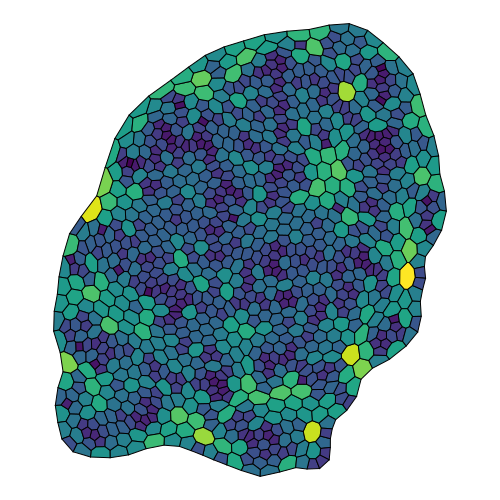

In [35]:
vert_order=[vec(get_vert_order(A,B, i)[1]) for i in 1:nCells]
cellPolygons = get_Polygons(R,nCells, vert_order)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=cellAreas[i], colorrange=(minimum(cellAreas), maximum(cellAreas)), strokecolor=:black, strokewidth=1)
end


resize_to_layout!(fig)
fig

In [36]:
Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
sum(cellAreas.*Peff)
Q=get_Q(cellPerimeters, edgeTangents,  B̄)
J=[Q[i]-(I./2) for i in 1:nCells]
cellShearStress=cellShears(cellTensions, cellPerimeters, cellAreas, Q)
sum(cellPerimeters.*cellTensions.*J)


2×2 Matrix{Float64}:
  0.00263749  -0.00621917
 -0.00621917  -0.00263749

In [7]:
function new_cev_vecs(A, B)
    nVerts=size(A)[2]
    nEdges=size(A)[1]
    nCells=size(B)[1]
    edgesP=vec((abs.(ones(nCells)'*B)))
    vertsP=vec((0.5.*edgesP'*abs.(A))')
    edgesB=vec(abs.(A*(ones(nVerts).-vertsP)))
    edgesI=vec(ones(nEdges).-edgesB.-edgesP)
    vertsI=vec(ones(nVerts)-vertsP)
    cellsB=vec(abs.(abs.(B)*edgesP))
    cellsB[findall(x->x!=0,cellsB)].=1
    cellsI=ones(nCells)-cellsB
    
    edgesI=((abs.(B))'*Diagonal(cellsI)*abs.(B))*edgesI
    edgesI[findall(x->x!=0, edgesI)].=1


    vertsI=((abs.(A))'*Diagonal(edgesI)*abs.(A))*vertsI
    vertsI[findall(x->x!=0, vertsI)].=1


    return edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI
end

function update_matrices(A, B,R, cellsI, edgesI, vertsI)
    Bint=B[cellsI.>0, edgesI.>0]
    Aint=A[edgesI.>0, vertsI.>0]
    Rint=R[vertsI.>0]
    nCellsint=size(Bint)[1]
    vert_order_int=[vec(get_vert_order(Aint,Bint, i)[1]) for i in 1:nCellsint]
    return Aint, Bint,Rint, nCellsint, vert_order_int
end

function update_quantities(cellsI, cellAreas, cellPerimeters, cellTensions, cellPressures, J)
    cellAreasint=cellAreas[cellsI.>0]
    cellPerimetersint=cellPerimeters[cellsI.>0]
    cellTensionsint=cellTensions[cellsI.>0]
    cellPressuresint=cellPressures[cellsI.>0]
    Jint=J[cellsI.>0];
    Peffint=cellPressuresint.+(cellPerimetersint.*cellTensionsint)./(2*cellAreasint)
    return cellAreasint, cellPerimetersint, cellTensionsint, cellPressuresint, Jint, Peffint
end


function get_glob_stresses(cellAreas, cellPerimeters, cellTensions, Peff, J)
    isotropic=sum(cellAreas.*Peff)
    dev=sum(cellPerimeters.*cellTensions.*J)
    return isotropic, dev    
end

get_glob_stresses (generic function with 1 method)

nCells = 547, isotropic = 3.0327146203570355e-7, Pext = 2.571457305562468e-9, dev = [3.7903420382612895e-5 -6.599607681802973e-5; -6.599607681812736e-5 -3.790342038418999e-5]
nCells = 469, isotropic = 2.7923087389497124e-7, Pext = 2.7613769292478145e-9, dev = [3.787128558573588e-5 -6.594539251774631e-5; -6.594539251778964e-5 -3.787128558751953e-5]
nCells = 397, isotropic = 2.5043798569174614e-7, Pext = 2.925801070352842e-9, dev = [3.771506422413289e-5 -6.569517571334028e-5; -6.569517571337277e-5 -3.771506422492138e-5]
nCells = 331, isotropic = 2.1817301062999636e-7, Pext = 3.0570893349577152e-9, dev = [3.73262963561965e-5 -6.506687642077146e-5; -6.506687642084203e-5 -3.732629635704138e-5]
nCells = 271, isotropic = 1.837251324465756e-7, Pext = 3.1443753090844602e-9, dev = [3.669494256229337e-5 -6.404630054971802e-5; -6.404630054978591e-5 -3.669494256319459e-5]
nCells = 217, isotropic = 1.4835907589391108e-7, Pext = 3.170950662677357e-9, dev = [3.580281043588611e-5 -6.260794176221607e-5;

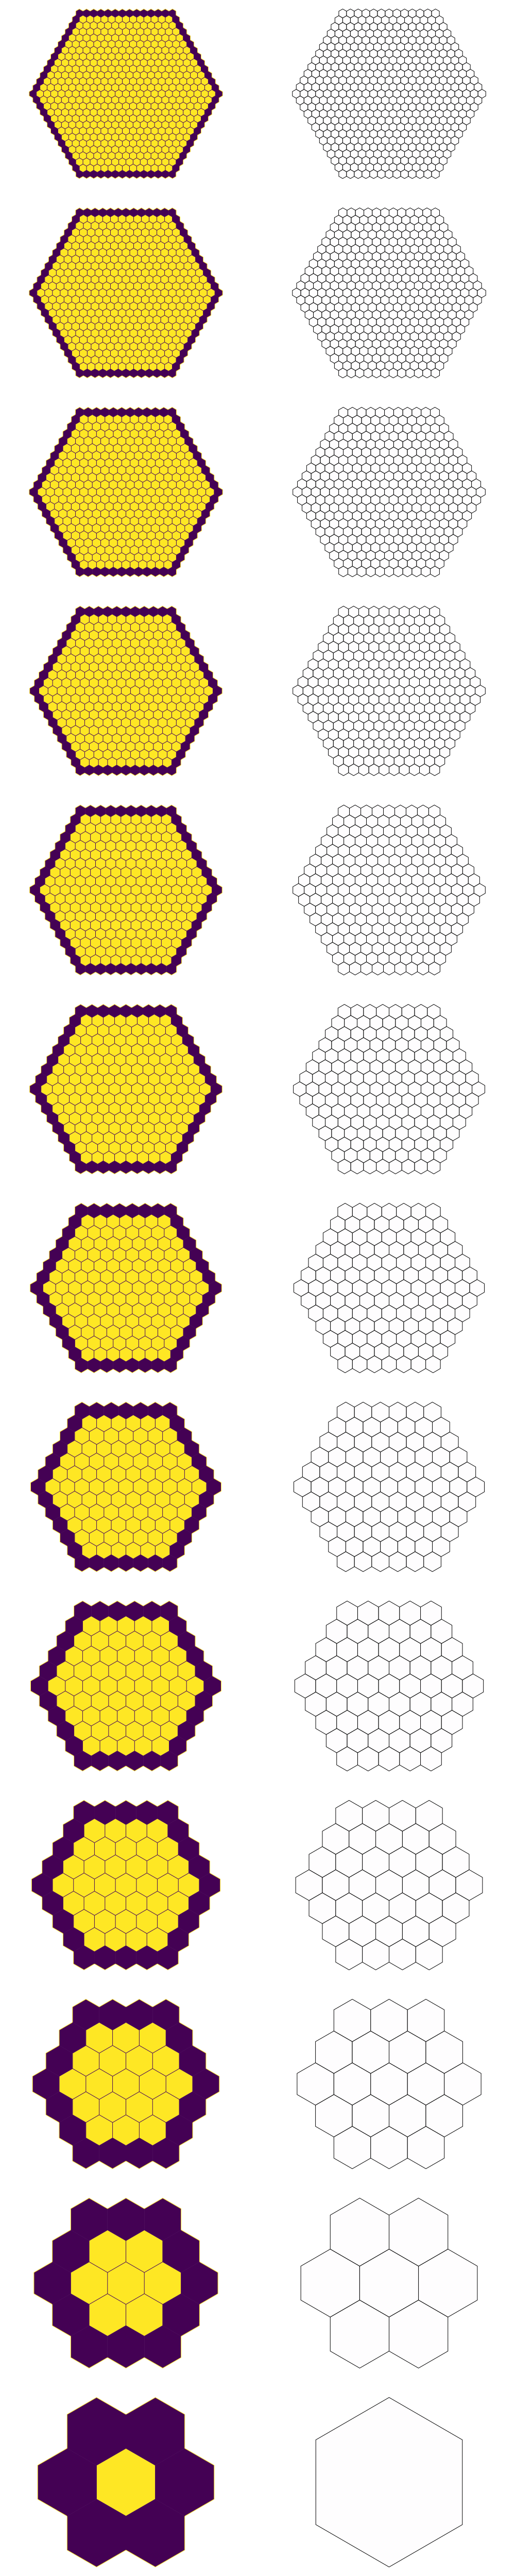

CairoMakie.Screen{IMAGE}


In [31]:
Pext= zeros(0)
APext= zeros(0)


Aloop=A
Bloop=B
Rloop=R
Nc=nCells
vert_order=cellVertexOrders
areas=cellAreas
perimeters=cellPerimeters
tensions=cellTensions
pressures=cellPressures
Peff=cellPressures+(cellPerimeters.*cellTensions)./(2*cellAreas)
Q=get_Q(cellPerimeters, edgeTangents,  B̄)
J=[Q[i]-(I./2) for i in 1:nCells]
edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=new_cev_vecs(Aloop,Bloop)
iso, dev=get_glob_stresses(areas, perimeters, tensions, Peff, J);
pext=iso/sum(areas);
print("nCells = ", size(Bloop)[1], ", isotropic = ",iso,", Pext = ", pext, ", dev = " , dev ,"\n")
push!(Pext, pext)
push!(APext, iso)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1000,5000))

for n in 1:13
    edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=new_cev_vecs(Aloop,Bloop);

    cellPolygons = get_Polygons(Rloop, Nc, vert_order)

    a1=Axis(fig[n,1],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)

    for i=1:size(Bloop)[1]
        poly!(a1,cellPolygons[i], color=cellsI[i], colorrange=(0,1))
    end

    for j=1:size(Bloop)[2]
        lines!([Rloop[findall(x->x==-1, Aloop[j, 1:end])][1][1],Rloop[findall(x->x==1, Aloop[j, 1:end])][1][1]],[Rloop[findall(x->x==-1, Aloop[j, 1:end])][1][2],Rloop[findall(x->x==1, Aloop[j, 1:end])][1][2]],color=edgesP[j], colorrange=(0,1), linewidth=1)
    end


    Aloop, Bloop,Rloop, Nc, vert_order=update_matrices(Aloop, Bloop,Rloop, cellsI, edgesI, vertsI);
    areas, perimeters, tensions, pressures, J, Peff=update_quantities(cellsI, areas, perimeters, tensions, pressures, J);
    iso, dev=get_glob_stresses(areas, perimeters, tensions, Peff, J);

    a2=Axis(fig[n,2],aspect=DataAspect())
    hidedecorations!(a2)
    hidespines!(a2)
    cellPolygons = get_Polygons(Rloop, Nc, vert_order)

    for i=1:size(Bloop)[1]
        poly!(a2,cellPolygons[i], color=Peff[i], colorrange=(-1,1), colormap=:bwr, strokecolor=(:black, 1), strokewidth=1)
    end
 
    pext=iso/sum(areas)
    print("nCells = ", size(Bloop)[1], ", isotropic = ",iso,", Pext = ", pext, ", dev = " , dev ,"\n")
    push!(Pext, pext)
    push!(APext, iso)

end

resize_to_layout!(fig)
display(fig)
save(datadir(f,"patch_stress","Peff_n_547.png"),fig)


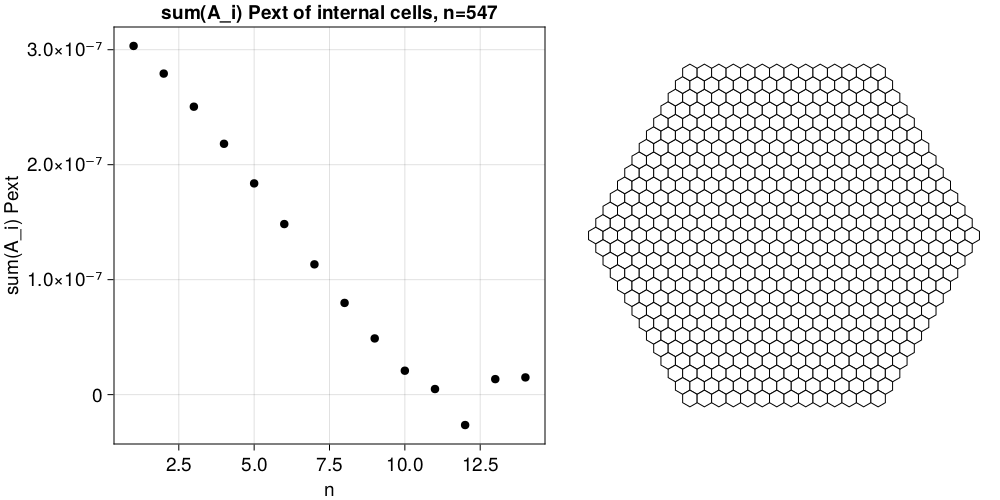

In [33]:
fig = Figure( resolution=(1000, 500))
ax=Axis(fig[1, 1], xlabel="n", ylabel="sum(A_i) Pext", title="sum(A_i) Pext of internal cells, n=547")
plot!(ax, APext)
ax2=Axis(fig[1,2], aspect=DataAspect())
cellPolygons = makeCellPolygons(R,params,matrices)
hidedecorations!(ax2)
hidespines!(ax2)

for i=1:nCells
    poly!(ax2,cellPolygons[i], color=:white, strokecolor=:black, strokewidth=1)
end

save(datadir(f,"patch_stress","APext_n_547.png"),fig)
fig

In [37]:
edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=new_cev_vecs(A,B);
Aint, Bint,Rint, Nc, vert_order=update_matrices(A, B,R, cellsI, edgesI, vertsI);
areas, perimeters, tensions, pressures, J, Peff=update_quantities(cellsI, cellAreas, cellPerimeters, cellTensions, cellPressures, J);

In [46]:
params.nCells

1000

In [45]:
nCells = size(Bint, 1)
nEdges = size(Aint, 1)
nVerts = size(Aint, 2)


1922

In [51]:
cellTimeToDivide = rand(Uniform(0.0,0.1*5000),size(B,1))
matrices = MatricesContainer(
    Aint,
    Bint,
    spzeros(Int64, nVerts, nEdges),                       # Aᵀ
    spzeros(Int64, nEdges, nVerts),                       # Ā
    spzeros(Int64, nVerts, nEdges),                       # Āᵀ
    spzeros(Int64, nEdges, nCells),                       # Bᵀ
    spzeros(Int64, nCells, nEdges),                       # B̄
    spzeros(Int64, nEdges, nCells),                       # B̄ᵀ
    spzeros(Int64, nCells, nVerts),                       # C
    zeros(Int64, nCells),                                 # cellEdgeCount
    fill(CircularVector(Int64[]), nCells),                # cellVertexOrders
    fill(CircularVector(Int64[]), nCells),                # cellEdgeOrders
    zeros(Int64, nVerts),                                 # boundaryVertices
    zeros(Int64, nEdges),                                 # boundaryEdges
    fill(SVector{2,Float64}(zeros(2)), nCells),           # cellPositions
    zeros(nCells),                                        # cellPerimeters
    fill(SMatrix{2,2,Float64}(zeros(2,2)), nCells),       # cellOrientedAreas
    zeros(nCells),                                        # cellAreas
    zeros(nCells),                                        # cellTensions
    zeros(nCells),                                        # cellPressures
    cellTimeToDivide,                                     # cellTimeToDivide
    ones(nCells),                                         # μ
    γ.*ones(nCells),                                      # Γ
    zeros(nEdges),                                        # edgeLengths
    fill(SVector{2,Float64}(zeros(2)), nEdges),           # edgeTangents
    fill(SVector{2,Float64}(zeros(2)), nEdges),           # edgeMidpoints
    spzeros(SVector{2,Float64}, nCells, nVerts),          # edgeMidpointLinks
    zeros(nEdges),                                        # timeSinceT1
    ones(nVerts),                                         # vertexAreas
    spzeros(SVector{2,Float64}, nVerts, nCells),          # F
    fill(SVector{2,Float64}(zeros(2)), nVerts),           # externalF
    fill(SVector{2,Float64}(zeros(2)), nVerts),           # totalF
    SMatrix{2, 2, Float64}([                              # ϵ Clockwise rotation matrix setting orientation of cell faces
    0.0 1.0
    -1.0 0.0
    ])        )


    params = ParametersContainer(
        initialSystem,
        nCells,
        nEdges,
        nVerts,
        γ,
        λ,
        L₀,
        A₀,
        pressureExternal,
        outputTotal,
        outputInterval,
        viscousTimeScale,
        realTimetMax,
        tMax,
        realCycleTime,
        nonDimCycleTime,
        t1Threshold,
        peripheralTension,
        seed,
        LogNormal(0.0, 0.2)
    )


UndefVarError: UndefVarError: `Uniform` not defined

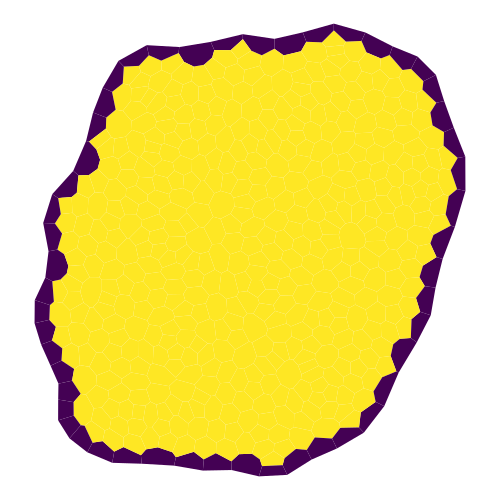

In [182]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
Levlims=(minimum(abs.(cellPerimeters[1:nCells])), maximum(abs.(cellPerimeters[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=intcells[i], colorrange=(0,1))
end

# for j=1:nEdges
#     lines!([R[findall(x->x==-1, A[j, 1:end])][1][1],R[findall(x->x==1, A[j, 1:end])][1][1]],[R[findall(x->x==-1, A[j, 1:end])][1][2],R[findall(x->x==1, A[j, 1:end])][1][2]],color=edgesB[j], colorrange=(0,1), linewidth=1)
# end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)




resize_to_layout!(fig)
fig

In [229]:

sum(cellsI.*cellAreas.*Peff)
sum(cellsI.*cellPerimeters.*cellTensions.*J)



2×2 Matrix{Float64}:
  0.0622845  -1.65756
 -1.65756    -0.0622845

In [257]:
Bint=B[cellsI.>0, edgesI.>0]
Aint=A[edgesI.>0, vertsI.>0]
Rint=R[vertsI.>0]
nCellsint=size(Bint)[1]
vert_order_int=[vec(get_vert_order(Aint,Bint, i)[1]) for i in 1:nCellsint]

Rint[vert_order_int[1]]
cellAreasint=cellAreas[cellsI.>0]
cellPerimetersint=cellPerimeters[cellsI.>0]
cellTensionsint=cellTensions[cellsI.>0]
cellPressuresint=cellPressures[cellsI.>0]
Jint=J[cellsI.>0];
Peffint=cellPressuresint.+(cellPerimetersint.*cellTensionsint)./(2*cellAreasint)

450-element Vector{Float64}:
 -0.24381345703764623
  0.03828049789355625
 -0.13173536086835425
 -0.3448359267605332
 -0.39735442314794267
 -0.09190408676027784
 -0.3401827472564263
 -0.19124402216580005
 -0.19546785097345154
  0.30468157930732276
  ⋮
 -0.39968359321582536
 -0.29212088873755504
 -0.17787605485428526
 -0.6755386529329206
 -0.4094819742674001
 -0.107650907848452
 -0.14785933925693584
 -0.05328846639117857
 -0.5617125462248054

In [260]:
print(sum(cellAreasint.*Peffint))
print("\n")
print(sum(cellPerimetersint.*cellTensionsint.*Jint))

-8.336820224878798
[0.06228451752300216 -1.6575559652608565; -1.6575559652608576 -0.0622845175230005]

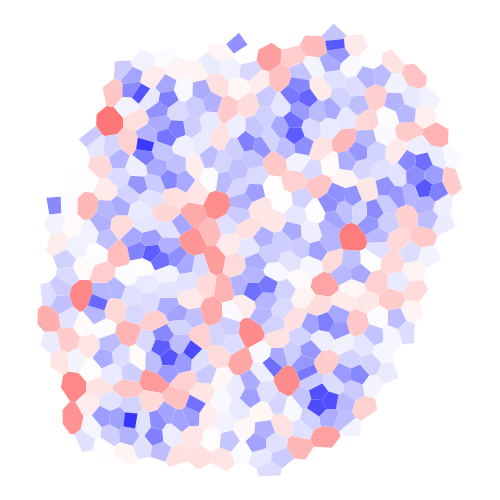

In [266]:
cellPolygons = get_Polygons(Rint, nCellsint, vert_order_int)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCellsint
    poly!(a1,cellPolygons[i], color=Peffint[i], colorrange=(-1,1), colormap=:bwr)
end

# for j=1:nEdges
#     lines!([R[findall(x->x==-1, A[j, 1:end])][1][1],R[findall(x->x==1, A[j, 1:end])][1][1]],[R[findall(x->x==-1, A[j, 1:end])][1][2],R[findall(x->x==1, A[j, 1:end])][1][2]],color=edgesB[j], colorrange=(0,1), linewidth=1)
# end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

resize_to_layout!(fig)
fig

In [291]:
nVertsint=size(Aint)[2]
nEdgesint=size(Aint)[1]
edgesPint=vec((abs.(ones(nCellsint)'*Bint)))
vertsPint=vec((0.5.*edgesPint'*abs.(Aint))')
edgesBint=vec(abs.(Aint*(ones(nVertsint).-vertsPint)))
edgesIint=vec(ones(nEdgesint).-edgesBint.-edgesPint)
vertsIint=vec(ones(nVertsint)-vertsPint)
cellsBint=vec(abs.(abs.(Bint)*edgesPint))
cellsBint[findall(x->x!=0,cellsBint)].=1
cellsIint=ones(nCellsint)-cellsBint

450-element Vector{Float64}:
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0

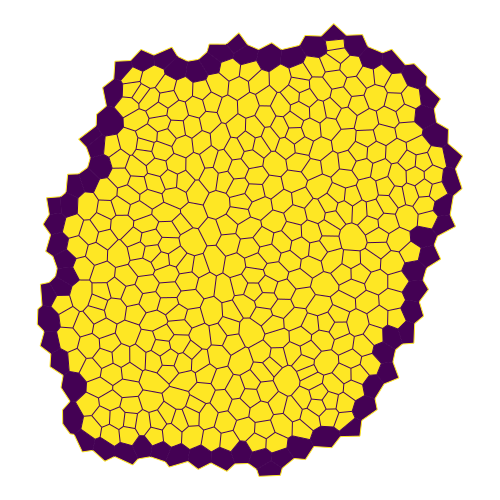

In [293]:
cellPolygons = get_Polygons(Rint, nCellsint, vert_order_int)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCellsint
    poly!(a1,cellPolygons[i], color=cellsIint[i], colorrange=(0,1))
end

for j=1:nEdgesint
    lines!([Rint[findall(x->x==-1, Aint[j, 1:end])][1][1],Rint[findall(x->x==1, Aint[j, 1:end])][1][1]],[Rint[findall(x->x==-1, Aint[j, 1:end])][1][2],Rint[findall(x->x==1, Aint[j, 1:end])][1][2]],color=edgesPint[j], colorrange=(0,1), linewidth=1)
end

#hidedecorations!(ax22)
#hidespines!(ax22)




resize_to_layout!(fig)
fig

In [296]:
Aint2, Bint2, Rint2, nCellsint2, vert_order_int2=update_matrices(Aint, Bint,Rint, cellsIint, edgesIint, vertsIint)

cellAreasint2, cellPerimetersint2, cellTensionsint2, cellPressuresint2, Jint2, Peffint2=update_quantities(cellsIint, cellAreasint, cellPerimetersint, cellTensionsint, cellPressuresint, Jint)

([0.23071350681855562, 0.3061664674579384, 0.20820524865786671, 0.20537215876069803, 0.2728623702298546, 0.21702405924355606, 0.24403478166735226, 0.24845187164158156, 0.3563585155357563, 0.26315078457640695  …  0.18731480422958446, 0.2135734808722436, 0.20188329874276878, 0.21173842203843685, 0.24488385662589673, 0.14115268714092366, 0.20276675626095075, 0.25783937052146766, 0.2670978595669369, 0.17908555319793507], [1.844013430200674, 2.0644397957264764, 1.7757662563394372, 1.746542146917295, 1.9589725361719055, 1.7828833879951316, 1.8820335455325776, 1.881737207926287, 2.2942134284924687, 1.9206479648118662  …  1.7188397804527409, 1.7701311017031474, 1.7435938386389715, 1.8059047226892724, 1.8904961574885657, 1.5808994459386037, 1.738932382115284, 1.9407695995804255, 1.980571376158109, 1.6522467176677407], [0.30597220414848275, 0.3624294521229922, 0.28711601174340773, 0.27881895859537337, 0.33621005977711604, 0.28911596730411027, 0.31617643270529655, 0.3160976984713822, 0.4151950260

In [297]:
print(sum(cellAreasint2.*Peffint2))
print("\n")
print(sum(cellPerimetersint2.*cellTensionsint2.*Jint2))


-9.653713282556222
[0.2942374997242267 -1.2328495951032503; -1.2328495951032499 -0.2942374997242249]

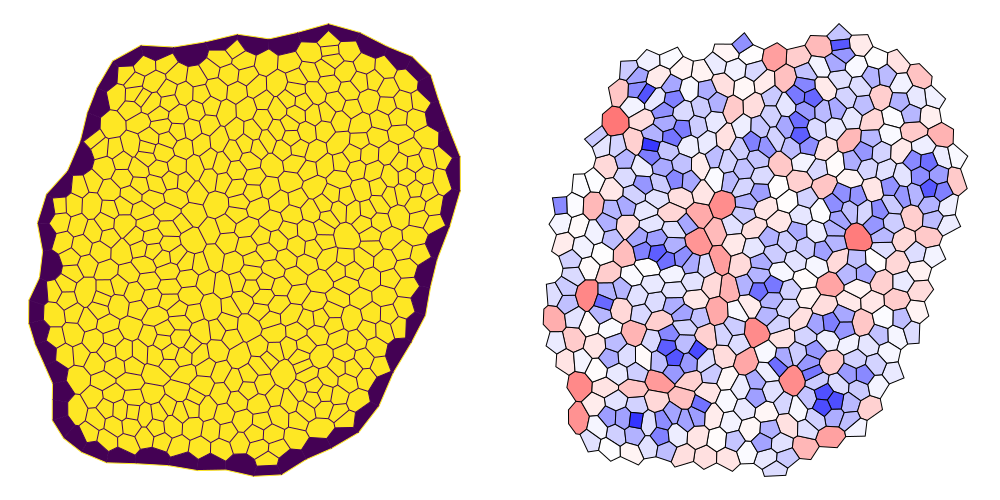

In [310]:
cellPolygons = get_Polygons(R, nCells, cellVertexOrders)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1000,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=cellsI[i], colorrange=(0,1))
end

for j=1:nEdges
    lines!([R[findall(x->x==-1, A[j, 1:end])][1][1],R[findall(x->x==1, A[j, 1:end])][1][1]],[R[findall(x->x==-1, A[j, 1:end])][1][2],R[findall(x->x==1, A[j, 1:end])][1][2]],color=edgesP[j], colorrange=(0,1), linewidth=1)
end


cellPolygons = get_Polygons(Rint, nCellsint, vert_order_int)


a2=Axis(fig[1,2],aspect=DataAspect())
hidedecorations!(a2)
hidespines!(a2)

for i=1:nCellsint
    poly!(a2,cellPolygons[i], color=Peffint[i], colorrange=(-1,1), colormap=:bwr,strokecolor=(:black,1), strokewidth=1)
end


# for j=1:nEdges
#     lines!([R[findall(x->x==-1, A[j, 1:end])][1][1],R[findall(x->x==1, A[j, 1:end])][1][1]],[R[findall(x->x==-1, A[j, 1:end])][1][2],R[findall(x->x==1, A[j, 1:end])][1][2]],color=edgesB[j], colorrange=(0,1), linewidth=1)
# end


resize_to_layout!(fig)
fig